# Python code for Optimising POI article for toy example:
 

# Importing all the relevant packages

In [ ]:
import pandas as pd
import numpy as np
import csv
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from numpy.linalg import inv
from sklearn.cluster import KMeans
from scipy.special import rel_entr
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as cx
import networkx as nx
import os
from shapely.geometry import Polygon
# Enable inline plotting
%matplotlib inline

# Import Datasets

In [2]:
#Import Grid_Neighbours_Labels. 
# Grid_Name and Grid_Name2 indicates the the structural nodes adjacent to each other. 
base_path = 'filepath'
file_path = os.path.join(base_path, 'Grid_Neighbours_Labels.txt')

DF = pd.read_csv(file_path, sep='|')
print(DF.head())

   Grid_Name  Grid_Name2
0          1           1
1          2           1
2          6           1
3          7           1
4          1           2


In [3]:
# Gives the attributes per grid. Each additional attribute will be added in another column the code is dynically set-up that way to pick up all distinct levels in all attributes provided
file_path1 = os.path.join(base_path, 'Grid_Attributes.txt')

Attributes = pd.read_csv(file_path1, sep='|')
Attributes = Attributes.sort_values(by='grid_name')
print(Attributes.head())

   grid_name attribute1 attribute2
0          1         A1         B1
1          2         A1         B1
2          3         A1         B1
3          4         A2         B1
4          5         A2         B1


In [4]:
# Degrees File. Distinct on grid_name and give the total number of neighbouring structural nodes(total) 
DF2 = pd.read_csv('//cenana01/testcode/pythonUserVenv/michelled/Virtual_Environment/Graph Mincut/Spatial Statistics/Grid_Degrees.txt', sep='|')

file_path2 = os.path.join(base_path, 'Grid_Degrees.txt')

# Read the file
DF2 = pd.read_csv(file_path2, sep='|')
DF2 = DF2.sort_values(by='grid_name')
print(DF2.head())

nodes=len(DF2.index)

    grid_name  Total
0           1      4
11          2      6
13          3      6
14          4      6
15          5      4


In [5]:
#Import shapefile, for this case it will be the grids
shapefile_path = '//cenana01/testcode/pythonUserVenv/michelled/Virtual_Environment/Graph Mincut/Spatial Statistics/Toy_Example_20Grids.shp'
gdf = gpd.read_file(shapefile_path)
gdf = gdf.sort_values(by='grid_name')

# Create Adjacency Matrix

In [6]:
#Using the information from DF create adjacency matrix 
df = pd.crosstab(DF.Grid_Name, DF.Grid_Name2)
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)

#Create correct format in Links table (new adjacency matrix)
links = np.matrix(df).astype(np.float64)

np.fill_diagonal(links, 0)

# Import the attributes and create attribute matrix X with N the number of structural nodes, A the total number of attributes and T total number of unique levels over all attributes

In [7]:
# Step 1: Order by grid_name
Attributes_sorted = Attributes.sort_values(by='grid_name')

# Step 2: Drop grid_name
Attributes_dropped = Attributes_sorted.drop(columns=['grid_name'])

# Step 3: Stack remaining columns into attributes_raw
attributes_raw = np.column_stack([Attributes_dropped[col].values for col in Attributes_dropped.columns])

# Convert the attributes_raw matrix to a DataFrame
df_attributes = pd.DataFrame(attributes_raw)
df_attributes.columns = df_attributes.columns.astype(str)

# Count the number of attributes (M)
A = df_attributes.shape[1]
N = links.shape[1]

# Extract all unique values across all attributes
distinct_values = np.unique(attributes_raw)

# Count the number of distinct values in all attributes (ki)
T = len(distinct_values)

# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the categorical variables
attributes_encoded = encoder.fit_transform(df_attributes).toarray()

# Extract feature names from the encoder
feature_names = encoder.get_feature_names_out(df_attributes.columns)

# Create a new DataFrame with one-hot encoded columns
df_encoded = pd.DataFrame(attributes_encoded, columns=feature_names)

# Attribute matrix X
X = df_encoded.values

X = X.astype(np.float64)

print(N)
print(A)
print(T)

20
2
4


In [8]:
#Structural weights, if all is 1 it it equal to the adjacency matrix
w0=links
# Create w with the weights of the attributes
w = np.full(A, 1)

#Shell for transition matrix
transition_matrix = np.zeros((N + T, N + T))

#Sum over the rows of structural weights w0
row_sums = w0.sum(axis=1)
row_sums=row_sums.reshape((N, 1))

#sum over the rows of the attribute weights
attributes_sums = X.T.sum(axis=1)
attributes_sums=attributes_sums.reshape((T, 1))

# Create shell for submatrices with zeros
Matrix_Ps = np.zeros((N, N))
Matrix_Psa_Structure = X
Matrix_Pas=np.zeros((T,N))
Matrix_Pas_Structure = X.T
Matrix_0 = np.zeros((T, T))


# Create a dictionary to map attribute values to their corresponding weights
weights_dict = {}
for i in range(A):
    col_values = np.unique(df_attributes.iloc[:, i])
    for val in col_values:
        weights_dict[val] = w[i]

# Create the row vector w with the corresponding weights
wj = np.array([weights_dict[val] for val in distinct_values])
sum_weights=np.sum(w)

#From equations on page 3 and 4 the values for submatrices
Matrix_Ps=w0/(row_sums+sum_weights)

Matrix_A=wj/(row_sums+sum_weights)
Matrix_A = np.asarray(Matrix_A)
Matrix_A *= Matrix_Psa_Structure

Matrix_Psa_Structure = np.asarray(Matrix_Psa_Structure)

Matrix_Pas=(1/attributes_sums) * Matrix_Pas_Structure

transition_matrix=np.vstack((np.hstack((Matrix_Ps,Matrix_A)),np.hstack((Matrix_Pas,Matrix_0))))
P=transition_matrix
P = np.round(transition_matrix, 6)

# Check if matrix is stochastic

In [9]:
def is_row_stochastic(matrix):
    # Check non-negativity
    if np.any(matrix < 0):
        return False
    # Check if each row sum is within the range [0.99, 1.01]
    row_sums = matrix.sum(axis=1)
    return np.all((row_sums >= 0.99) & (row_sums <= 1.01))

# Example usage:
print("Is row stochastic?", is_row_stochastic(P))

Is row stochastic? True


# Results if the optimal clustering results of U was used

# Optimal clusters 

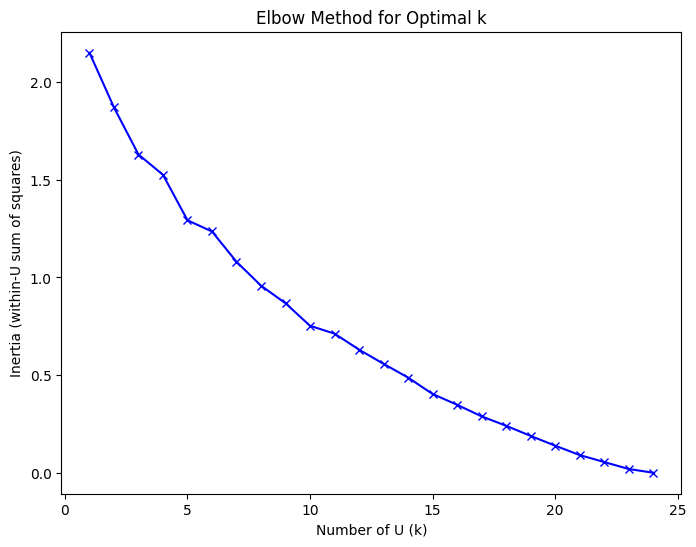

Iteration 0: Mutual Information I(t) = 24.5095
Iteration 1: Mutual Information I(t) = 13.3720
Iteration 2: Mutual Information I(t) = 19.5607
Iteration 3: Mutual Information I(t) = 15.1831
Iteration 4: Mutual Information I(t) = 16.2520
Iteration 5: Mutual Information I(t) = 14.2384
Iteration 6: Mutual Information I(t) = 14.9739
Iteration 7: Mutual Information I(t) = 14.2553
Iteration 8: Mutual Information I(t) = 15.2848
Iteration 9: Mutual Information I(t) = 14.6506
Iteration 10: Mutual Information I(t) = 15.7698
Iteration 11: Mutual Information I(t) = 14.4500
Iteration 12: Mutual Information I(t) = 16.7278
Iteration 13: Mutual Information I(t) = 15.6752
Iteration 14: Mutual Information I(t) = 12.7770
Iteration 15: Mutual Information I(t) = 13.9263
Iteration 16: Mutual Information I(t) = 13.2774
Iteration 17: Mutual Information I(t) = 13.1502
Iteration 18: Mutual Information I(t) = 13.2774
Cycle detected at iteration 18. Previous occurrence at iteration 16.
Iteration 19: Mutual Informat

In [10]:
# Set global random seed for reproducibility
np.random.seed(42)

# Step 0: Elbow method to find the optimal number of U
def find_optimal_U(P, max_k=25):
    max_k = min(max_k, P.shape[0])  # Ensure max_k does not exceed the number of samples
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(P)
        inertia.append(kmeans.inertia_)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_k + 1), inertia, 'bx-')
    plt.xlabel('Number of U (k)')
    plt.ylabel('Inertia (within-U sum of squares)')
    plt.title('Elbow Method for Optimal k')
    plt.show()
    optimal_k = int(input("Based on the Elbow plot, enter the optimal number of U: "))
    return optimal_k

# Step 1: Run the elbow method to find the optimal number of U
optimal_U = find_optimal_U(P)

# Step 2: Run KMeans with the optimal number of U
kmeans = KMeans(n_clusters=optimal_U, random_state=42, n_init=10).fit(P)
initial_U = kmeans.labels_

# Convert initial U to indicator matrix
U = np.eye(optimal_U)[initial_U]

# Step 3: Continue with the Cluster Membership and the rest of the process
def cluster_membership(P, U):
    return np.dot(P, U)

# Updated Mutual Information Calculation
def mutual_information(P, U, prev_cluster_prob):
    """
    Compute mutual information using cluster probabilities from the previous iteration.
    """
    n_states = P.shape[0]
    cluster_prob = np.mean(U, axis=0)  # Current cluster probabilities

    U_df = pd.DataFrame(U)
    pattern_counts = U_df.value_counts().reset_index(name='count')
    pattern_counts['probability'] = pattern_counts['count'] / len(U_df)
    U_df = U_df.merge(pattern_counts.iloc[:, :-1].join(pattern_counts[['probability']]), on=list(U_df.columns), how='left')
    pi_U = U_df['probability'].values.reshape(-1, 1)  # Column vector

    I_t = 0.0
    for i in range(n_states):
        for k in range(optimal_U):
            if U[i, k] > 0:  # Only consider non-zero probabilities
                I_t += prev_cluster_prob[k] * U[i, k] * np.log2(U[i, k] / pi_U[i, 0])
    return I_t

# Information Bottleneck Optimization
def information_bottleneck(P, U, n_iters=50):
    oscillating_solutions = []
    history = {}
    cluster_prob = np.mean(U, axis=0)  # Initial cluster probabilities
    prev_cluster_prob = cluster_prob.copy()  # Store initial probabilities as previous

    for t in range(n_iters):
        # Cluster Membership
        relaxed_U = cluster_membership(P, U)
        
        # Compute Mutual Information I(t) using prev_cluster_prob
        I_t = mutual_information(P, relaxed_U, prev_cluster_prob)
        print(f"Iteration {t}: Mutual Information I(t) = {I_t:.4f}")
        
        # Check for cycles
        current_state = round(I_t, 4)
        if current_state in history:
            print(f"Cycle detected at iteration {t}. Previous occurrence at iteration {history[current_state]}.")
            oscillating_solutions.append(U)
            if len(oscillating_solutions) == 2:
                break
        else:
            history[current_state] = t
        
        # Update U
        kmeans = KMeans(n_clusters=optimal_U, random_state=42, n_init=10).fit(relaxed_U)
        U = np.eye(optimal_U)[kmeans.labels_]
        
        # Update previous and current cluster probabilities
        prev_cluster_prob = cluster_prob
        cluster_prob = np.mean(U, axis=0)

    return oscillating_solutions

# Spatial Coherence Score Calculation
def spatial_coherence_score(U, adjacency_matrix):
    score = 0
    n_nodes = adjacency_matrix.shape[0]
    for i in range(n_nodes):
        for j in range(n_nodes):
            if adjacency_matrix[i, j] == 1:
                if np.argmax(U[i]) == np.argmax(U[j]):
                    score += 1
    return score

# Choose the best solution based on spatial coherence
def choose_best_solution(solution1, solution2, adjacency_matrix):
    score1 = spatial_coherence_score(solution1, adjacency_matrix)
    score2 = spatial_coherence_score(solution2, adjacency_matrix)
    print(f"Solution 1 Spatial Coherence Score: {score1}")
    print(f"Solution 2 Spatial Coherence Score: {score2}")
    if score1 > score2:
        print("Choosing Solution 1 for better spatial coherence.")
        return solution1
    else:
        print("Choosing Solution 2 for better spatial coherence.")
        return solution2

# Run Information Bottleneck Optimization and detect cycles
oscillating_solutions = information_bottleneck(P, U)

# If a cycle was detected, evaluate adjacency matrix
if len(oscillating_solutions) == 2:
    solution1 = oscillating_solutions[0]  
    solution2 = oscillating_solutions[1] 
    final_clusters = choose_best_solution(solution1, solution2, links)
else:
    print("No oscillation detected or fewer than two oscillating solutions.")

In [11]:
# Ensure 'final_clusters' is a DataFrame
final_clusters = final_clusters[:N]
final_clusters = pd.DataFrame(final_clusters)

# Convert numeric columns only (if needed) before further processing
final_clusters = final_clusters.apply(pd.to_numeric, errors='coerce').fillna(0)

# Find the index of the '1' for each row and add 1 to get cluster_name
final_clusters['cluster_name'] = final_clusters.apply(lambda row: np.argmax(row) + 1, axis=1)

# Add grid_name from Attributes
final_clusters['grid_name'] = Attributes['grid_name'].values

# Add character attributes as is (without conversion)
final_clusters['attribute1'] = Attributes['attribute1'].values
final_clusters['attribute2'] = Attributes['attribute2'].values

# Get the number of unique clusters
n_clusters = final_clusters['cluster_name'].nunique()
print(n_clusters)

# Print the result
print(final_clusters.head())

5
     0    1    2    3    4  cluster_name  grid_name attribute1 attribute2
0  0.0  1.0  0.0  0.0  0.0             2          1         A1         B1
1  0.0  1.0  0.0  0.0  0.0             2          2         A1         B1
2  0.0  1.0  0.0  0.0  0.0             2          3         A1         B1
3  0.0  0.0  0.0  0.0  1.0             5          4         A2         B1
4  0.0  0.0  0.0  0.0  1.0             5          5         A2         B1


In [12]:
# Convert both columns to string
gdf['grid_name'] = gdf['grid_name'].astype(str)
final_clusters['grid_name'] = final_clusters['grid_name'].astype(str)

# Merge the clustering results (final_clusters) with the shapefile geodataframe on 'SSAF_ID'
grids = gdf.merge(final_clusters[['grid_name', 'cluster_name', 'attribute1', 'attribute2']], on='grid_name')

# Create macro regions

In [13]:
#blobs or blob_id refers to the macro regions
def merge_adjacent_within_cluster(grids):
    """
    Merges only adjacent polygons within the same cluster while retaining separate groups.
    """
    # Create a spatial index to efficiently find adjacent polygons within the same cluster
    grids['dissolve_group'] = -1  # Initialize with -1 (or any unused number)
    
    group_counter = 0

    # Loop over each cluster to identify adjacent polygons within that cluster
    for cluster_name, group in grids.groupby('cluster_name'):
        # Create a spatial index for each cluster's group
        spatial_index = group.sindex

        for i, polygon in group.iterrows():
            if grids.at[polygon.name, 'dissolve_group'] == -1:  # If not yet assigned a group
                # Start a new group for this polygon
                grids.at[polygon.name, 'dissolve_group'] = group_counter
                
                # Use a stack to implement a depth-first search to find all connected polygons
                stack = [polygon.geometry]
                
                while stack:
                    current_polygon = stack.pop()
                    
                    # Find all adjacent polygons within the same cluster
                    possible_matches_index = list(spatial_index.intersection(current_polygon.bounds))
                    possible_matches = group.iloc[possible_matches_index]
                    
                    for j, match in possible_matches.iterrows():
                        if (grids.at[match.name, 'dissolve_group'] == -1 and 
                            match.geometry.touches(current_polygon)):
                            # Assign the same group and add to stack to check its neighbors
                            grids.at[match.name, 'dissolve_group'] = group_counter
                            stack.append(match.geometry)
                            
                group_counter += 1

    # Now, dissolve polygons based on the new 'dissolve_group' to create separate blobs
    dissolved = grids.dissolve(by=['cluster_name', 'dissolve_group'])
    dissolved['cluster_name'] = dissolved.index.get_level_values('cluster_name')
    dissolved['blob_id'] = range(1, len(dissolved) + 1)  # Assign a unique blob ID to each dissolved group

    return dissolved.reset_index(drop=True)

# Apply the merge function to keep adjacent polygons within the same cluster separate
blobs = merge_adjacent_within_cluster(grids)

# Spatially join the grids to assign each grid to a blob based on spatial containment
# This will add a 'blob_id' column to the original grids dataset
grids_with_blob_ids = gpd.sjoin(grids, blobs[['geometry', 'blob_id']], how='left', op='within')

# Now 'grids_with_blob_ids' has a new column 'blob_id' indicating the blob each grid belongs to
grids_with_blob_ids = grids_with_blob_ids.drop(columns='index_right')  # Drop unnecessary column from join

In [14]:
# Define a function to get the mode of a series - attribute segments
def mode(series):
    return series.mode()[0] if not series.mode().empty else None

# Group by 'cluster_name' and 'blob_id' and apply mode function to each group
mode_df = grids_with_blob_ids.groupby(['cluster_name']).agg({
    'attribute1': mode,
    'attribute2': mode
}).reset_index()

# Combine the attributes into a single string and factorize to assign a unique combination number
# Combination Number indicates the attribute segmentation
mode_df['combination'] = mode_df[['attribute1','attribute2']].agg('_'.join, axis=1)
mode_df['combination_number'] = pd.factorize(mode_df['combination'])[0] + 1  # Start numbering from 1

# Display the resulting DataFrame
print(mode_df)

   cluster_name attribute1 attribute2 combination  combination_number
0             1         A1         B1       A1_B1                   1
1             2         A1         B1       A1_B1                   1
2             3         A2         B2       A2_B2                   2
3             4         A2         B1       A2_B1                   3
4             5         A2         B1       A2_B1                   3


# Mapping attributes

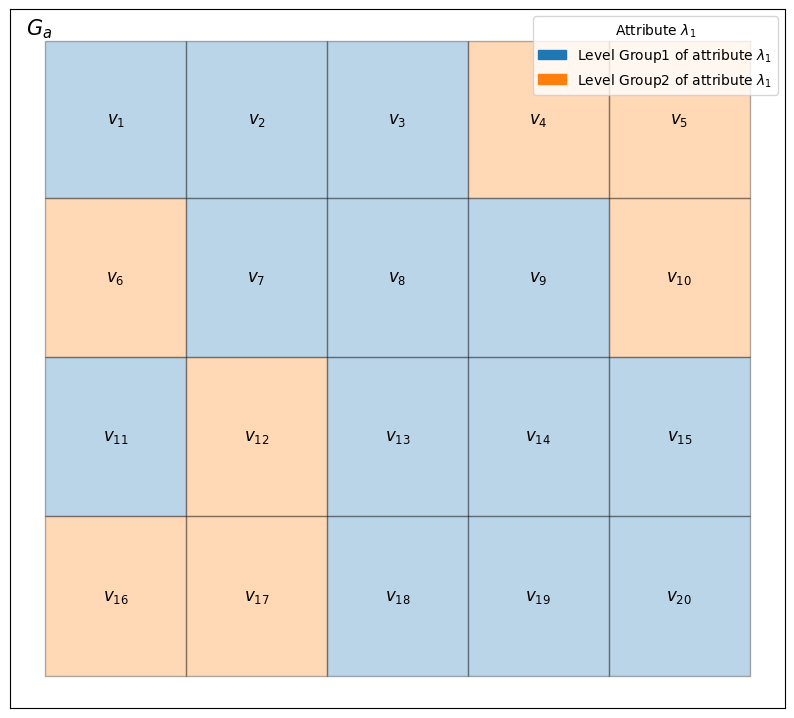

In [15]:
# Convert to Web Mercator projection (EPSG:3857)
df_wm2 = grids.to_crs(epsg=3857)

custom_labels = {
    'A1': 'Level Group1 of attribute $\lambda_1$',
    'A2': 'Level Group2 of attribute $\lambda_1$',
    # Add other mappings as needed
}

# Custom colours for A1 (Blue) and A2 (Orange)
custom_colors = {
    'A1': '#1f77b4',  # Blue
    'A2': '#ff7f0e'   # Orange
}

# Generating unique attributes (you can add more mappings as needed)
unique_attributes = df_wm2['attribute1'].unique()
category_colors = {attr: custom_colors.get(attr, '#cccccc') for attr in unique_attributes}  # Default colour if not specified

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
df_wm2.plot(
    column='attribute1',  # Column used for colour differentiation
    cmap=None,            # No 'tab20' colour map
    color=df_wm2['attribute1'].map(category_colors),  # Use your own colour mapping
    legend=False,
    ax=ax, edgecolor="k", alpha=0.3
)

legend_order = ['A1', 'A2']

# Custom legend
legend_patches = [mpatches.Patch(color=category_colors[attr], label=custom_labels.get(attr, attr))
                  for attr in legend_order]
ax.legend(handles=legend_patches, title="Attribute $\lambda_1$", loc='upper right')

# Adding LaTeX-style labels based on 'grid_name'
for x, y, label in zip(df_wm2.geometry.centroid.x, df_wm2.geometry.centroid.y, df_wm2['grid_name']):
    ax.text(x, y, f"$v_{{{label}}}$", fontsize=12, ha='center', va='center')

# Adding the label 'G_a' in the top left-hand corner
plt.text(0.02, 0.99, r"$G_a$", transform=ax.transAxes, fontsize=15, va='top', ha='left')

# Finalise the map
#plt.title('Attribute $\lambda_1$ associated with structural nodes $\{v_1, \ldots, v_{20}\}$', fontsize=14)
plt.xticks([])
plt.yticks([])
plt.show()

# Mapping some more attributes

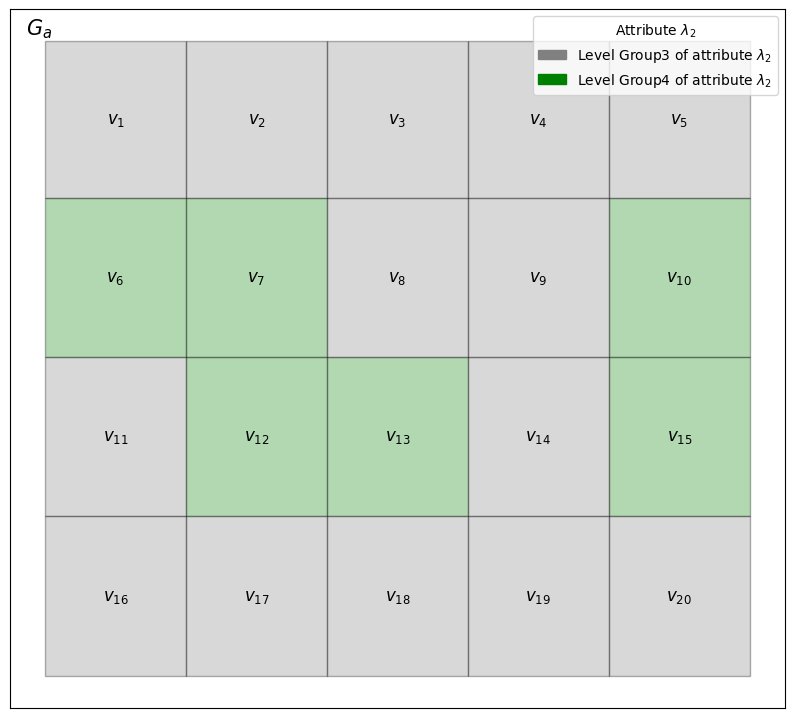

In [16]:
# Convert to Web Mercator projection (EPSG:3857)
df_wm = grids.to_crs(epsg=3857)

custom_labels = {
    'B1': 'Level Group3 of attribute $\lambda_2$',
    'B2': 'Level Group4 of attribute $\lambda_2$',
    # Add other mappings as needed
}

# Custom colours for A1 (Blue) and A2 (Orange)
custom_colors = {
    'B1': '#808080',  # Blue
    'B2': '#008000'   # Orange
}

# Generating unique attributes (you can add more mappings as needed)
unique_attributes = df_wm['attribute2'].unique()
category_colors = {attr: custom_colors.get(attr, '#cccccc') for attr in unique_attributes}  # Default colour if not specified

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
df_wm.plot(
    column='attribute2',  # Column used for colour differentiation
    cmap=None,            # No 'tab20' colour map
    color=df_wm2['attribute2'].map(category_colors),  # Use your own colour mapping
    legend=False,
    ax=ax, edgecolor="k", alpha=0.3
)

legend_order = ['B1', 'B2']

# Custom legend
legend_patches = [mpatches.Patch(color=category_colors[attr], label=custom_labels.get(attr, attr))
                  for attr in legend_order]
ax.legend(handles=legend_patches, title="Attribute $\lambda_2$", loc='upper right')

# Adding LaTeX-style labels based on 'grid_name'
for x, y, label in zip(df_wm.geometry.centroid.x, df_wm.geometry.centroid.y, df_wm['grid_name']):
    ax.text(x, y, f"$v_{{{label}}}$", fontsize=12, ha='center', va='center')

# Adding the label 'G_a' in the top left-hand corner
plt.text(0.02, 0.99, r"$G_a$", transform=ax.transAxes, fontsize=15, va='top', ha='left')

# Finalise the map
#plt.title('Attribute $\lambda_2$ associated with structural nodes $\{v_1, \ldots, v_{20}\}$', fontsize=14)
plt.xticks([])
plt.yticks([])
plt.show()

# Clusters on nodes

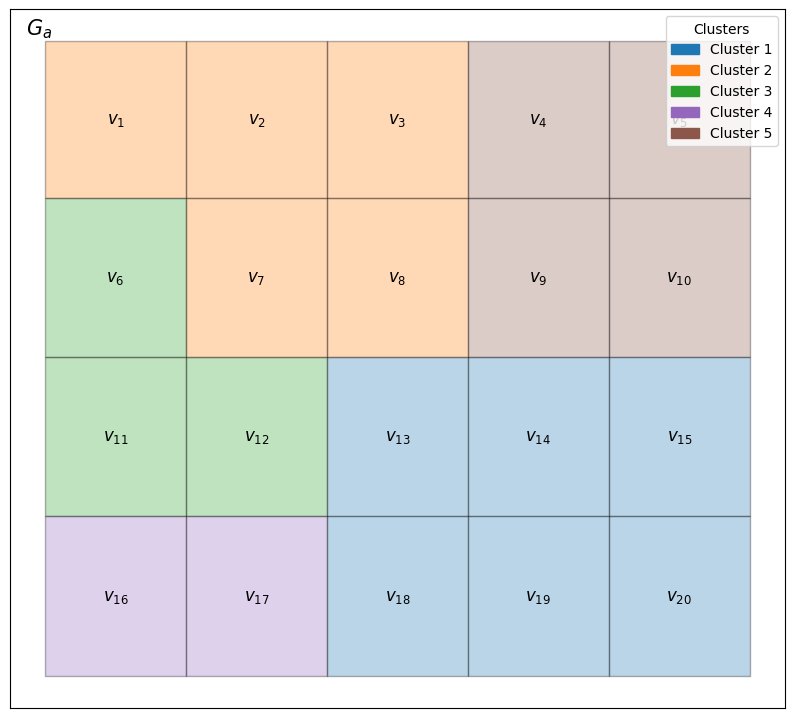

In [17]:
# Define the custom order for the legend
legend_order = ['1', '2', '3', '4', '5']  # Ensure these match the cluster_name values

# Custom labels and colours
custom_labels = {
    '1': 'Cluster 1',
    '2': 'Cluster 2',
    '3': 'Cluster 3',
    '4': 'Cluster 4',
    '5': 'Cluster 5'
}
custom_colors = {
    '1': '#1f77b4',  # Blue
    '2': '#ff7f0e',  # Orange
    '3': '#2ca02c',  # Blue
    '4': '#9467bd',  # Orange
    '5': '#8c564b'   # Orange
}

# Ensure all unique values are mapped
unique_attributes = df_wm2['cluster_name'].astype(str).unique()
category_colors = {attr: custom_colors.get(attr, '#cccccc') for attr in unique_attributes}

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
df_wm2.plot(
    color=df_wm2['cluster_name'].astype(str).map(category_colors),
    legend=False,
    ax=ax,
    edgecolor="k",
    alpha=0.3
)

# Custom legend in specified order
legend_patches = [
    mpatches.Patch(color=custom_colors[attr], label=custom_labels.get(attr, f"Cluster {attr}"))
    for attr in legend_order if attr in unique_attributes
]
ax.legend(handles=legend_patches, title="Clusters", loc='upper right')

# Adding LaTeX-style labels based on 'grid_name'
for x, y, label in zip(df_wm2.geometry.centroid.x, df_wm2.geometry.centroid.y, df_wm2['grid_name']):
    ax.text(x, y, f"$v_{{{label}}}$", fontsize=12, ha='center', va='center')

# Adding the label 'G_a' in the top left-hand corner
plt.text(0.02, 0.99, r"$G_a$", transform=ax.transAxes, fontsize=15, va='top', ha='left')

# Finalise the map
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# Macro regions

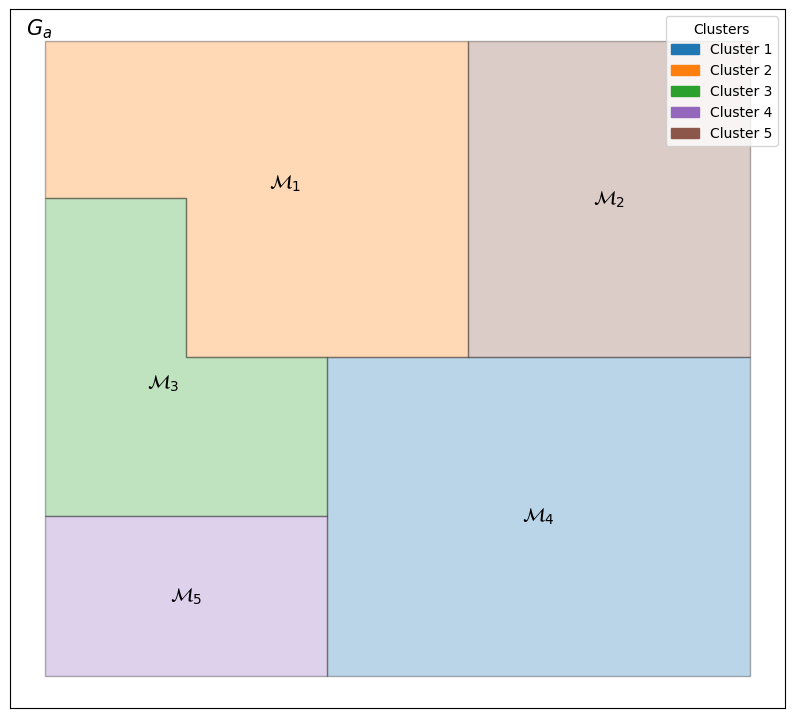

In [18]:
# Convert to Web Mercator projection
df_wm = blobs.to_crs(epsg=3857)

# Calculate the centroids of the polygons
df_wm['centroid'] = df_wm.geometry.centroid

# Manually assign colours to clusters
custom_colors = {
    '1': '#1f77b4',  # Blue
    '2': '#ff7f0e',  # Orange
    '3': '#2ca02c',  # Green
    '4': '#9467bd',  # Purple
    '5': '#8c564b'   # Brown
}

# Map the colours to the cluster_name column
df_wm['color'] = df_wm['cluster_name'].astype(str).map(custom_colors)

# Plot the polygons with the assigned colours
fig, ax = plt.subplots(figsize=(10, 10))
df_wm.plot(ax=ax, color=df_wm['color'], edgecolor='k', alpha=0.3)

# Create custom legend
cluster_labels = [f'Cluster {i}' for i in custom_colors.keys()]
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in zip(cluster_labels, custom_colors.values())]

plt.legend(handles=legend_patches, title='Clusters', loc='upper right')

# Adding LaTeX-style labels for each polygon based on blob_id
latex_labels = {
    1: r'$\mathcal{M}_4$',
    2: r'$\mathcal{M}_1$',
    3: r'$\mathcal{M}_3$',
    4: r'$\mathcal{M}_5$',
    5: r'$\mathcal{M}_2$',
    6: r'$\mathcal{M}_1$',
    7: r'$\mathcal{M}_6$'
}

# Add labels at the centroid positions based on blob_id
for idx, row in df_wm.iterrows():
    blob_id = row['blob_id']
    x, y = row['centroid'].x, row['centroid'].y
    if blob_id in latex_labels:
        ax.text(x, y, latex_labels[blob_id], fontsize=14, ha='center', va='center')

# Adding the label 'G_a' in the top left-hand corner
plt.text(0.02, 0.99, r"$G_a$", transform=ax.transAxes, fontsize=15, va='top', ha='left')

# Title and other plot settings
plt.xticks([])
plt.yticks([])
plt.show()

# Segmentation - Optimised number of clusters

In [19]:
cluster_mapping = mode_df.set_index('cluster_name')['combination_number'].to_dict()

# Use the mapping to overwrite the 'cluster_name' in both 'grids_with_blob_ids' and 'blobs'
grids_with_blob_ids['cluster_name'] = grids_with_blob_ids['cluster_name'].map(cluster_mapping)
blobs['cluster_name'] = blobs['cluster_name'].map(cluster_mapping)



# Attribute segments

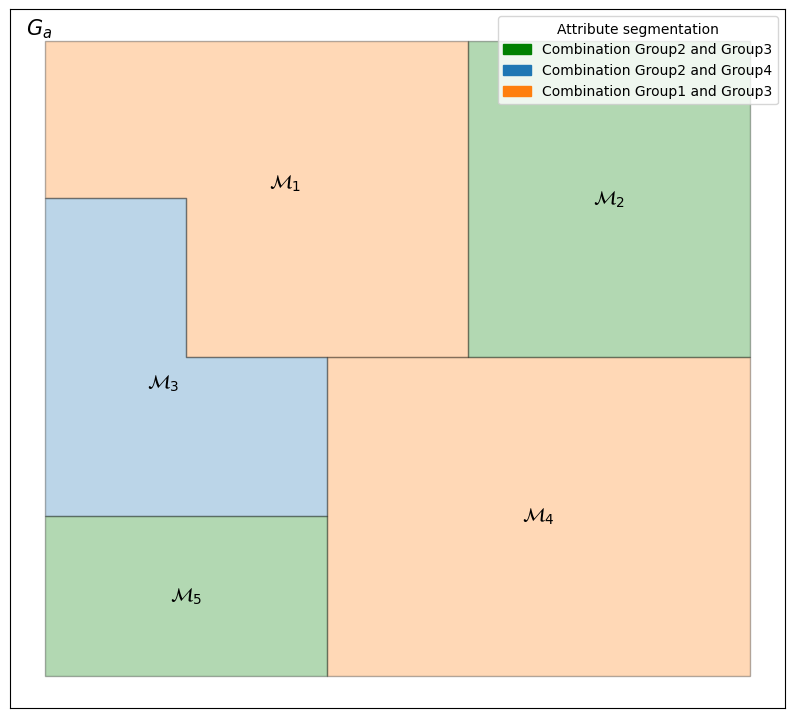

In [20]:
n_clusters = blobs['cluster_name'].nunique()

# Convert to Web Mercator projection
df_wm = blobs.to_crs(epsg=3857)

# Calculate centroids of the polygons
df_wm['centroid'] = df_wm.geometry.centroid

# Ensure centroids are available as a GeoSeries
centroids = df_wm['centroid']

# Mapping for custom labels (if needed)
custom_labels = {
    1: 'Combination Group1 and Group3',
    2: 'Combination Group2 and Group4',
    3: 'Combination Group2 and Group3'
}

# Custom colours for clusters (colouring is based on cluster_name)
custom_colors = {
    1: '#ff7f0e',  # Orange
    2: '#1f77b4',   # Blue
    3: '#008000'   # Blue
}

# Generating unique attributes and corresponding colors for cluster_name
unique_attributes = df_wm['cluster_name'].unique()
category_colors = {attr: custom_colors.get(attr, '#cccccc') for attr in unique_attributes}  # Default colour if not specified

# Plotting polygons with colours based on cluster_name
fig, ax = plt.subplots(figsize=(10, 10))
df_wm.plot(
    column='cluster_name', 
    color=df_wm['cluster_name'].map(category_colors),  # Use custom colour mapping for cluster_name
    legend=False, 
    ax=ax, 
    edgecolor="k", 
    alpha=0.3
)

legend_order = [3,2, 1]  # Modify this based on your desired legend order

# Custom legend
legend_patches = [mpatches.Patch(color=category_colors[attr], label=custom_labels.get(attr, f'Cluster {attr}'))
                  for attr in legend_order]
ax.legend(handles=legend_patches, title="Attribute segmentation", loc='upper right')



# Adding LaTeX-style labels for each polygon based on blob_id
# Adding LaTeX-style labels for each polygon based on blob_id
latex_labels = {  # Modify as necessary for your blob_ids
    1: r'$\mathcal{M}_4$',
    2: r'$\mathcal{M}_1$',
    3: r'$\mathcal{M}_3$',
    4: r'$\mathcal{M}_5$',
    5: r'$\mathcal{M}_2$',
    6: r'$\mathcal{M}_1$',
    7: r'$\mathcal{M}_6$'
}

# Add labels at the centroid positions based on blob_id
for idx, row in df_wm.iterrows():
    blob_id = row['blob_id']
    x, y = row['centroid'].x, row['centroid'].y
    if blob_id in latex_labels:
        ax.text(x, y, latex_labels[blob_id], fontsize=14, ha='center', va='center')

# Adding label and finalising plot
plt.text(0.02, 0.99, r"$G_a$", transform=ax.transAxes, fontsize=15, va='top', ha='left')
#plt.title('Attribute segmentation of clusters', fontsize=15)
plt.xticks([])
plt.yticks([])
plt.show()

# Network graph

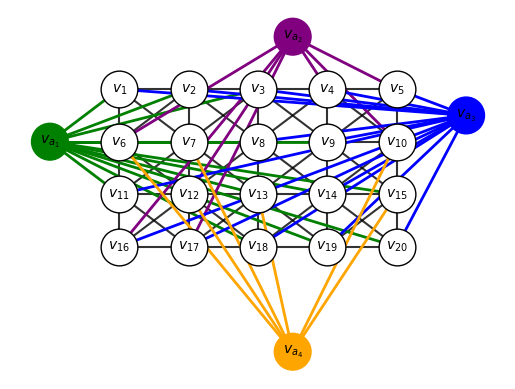

In [21]:
P_network = np.array(P)

# Define structural and attribute nodes with double subscripts
structural_nodes = [f"$v_{{{i+1}}}$" for i in range(20)]
attribute_nodes = [f"$v_{{a_{i+1}}}$" for i in range(4)]
node_labels = structural_nodes + attribute_nodes

# Create a graph
G = nx.Graph()
G.add_nodes_from(node_labels)

# Add edges from the adjacency matrix
for i in range(len(P_network)):
    for j in range(len(P_network[i])):
        if P_network[i, j] > 0:
            G.add_edge(node_labels[i], node_labels[j])

# Create a custom layout
pos = {}
# Position structural nodes in a 5x4 grid with spacing
grid_rows, grid_cols = 4, 5
spacing = 2  # Increase spacing between nodes
for i, node in enumerate(structural_nodes):
    row = i // grid_cols
    col = i % grid_cols
    pos[node] = (col * spacing, -row * spacing)

# Position attribute nodes on the outskirts
pos["$v_{a_1}$"] = (-spacing, -2)  # Moved closer to the left (was at right side)
pos["$v_{a_2}$"] = (grid_cols * spacing // 2, 2)  # Top
pos["$v_{a_3}$"] = (grid_cols * spacing, -1)  # Moved to right side (was at left)
pos["$v_{a_4}$"] = (grid_cols * spacing // 2, -(grid_rows + 1) * spacing)  # Bottom

# Define edge groups
structural_edges = [(u, v) for u, v in G.edges() if u in structural_nodes and v in structural_nodes]
attribute_edges = [
    (u, v) for u, v in G.edges() if u in attribute_nodes or v in attribute_nodes
]

# Separate attribute edges by node colour
Group1_edges = [(u, v) for u, v in attribute_edges if "$v_{a_1}$" in (u, v)]
Group2_edges = [(u, v) for u, v in attribute_edges if "$v_{a_2}$" in (u, v)]
Group3_edges = [(u, v) for u, v in attribute_edges if "$v_{a_3}$" in (u, v)]
Group4_edges = [(u, v) for u, v in attribute_edges if "$v_{a_4}$" in (u, v)]

# Draw structural edges (black) first
nx.draw_networkx_edges(G, pos, edgelist=structural_edges, edge_color='black', width=1.5, alpha=0.8)

# Draw structural nodes (white) on top of structural edges
nx.draw_networkx_nodes(G, pos, nodelist=structural_nodes, node_color='white', edgecolors='black', node_size=700)

# Draw attribute nodes with specific colours
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=["$v_{a_1}$", "$v_{a_2}$", "$v_{a_3}$", "$v_{a_4}$"],
    node_color=['green', 'purple', 'blue', 'orange'],
    edgecolors=['green', 'purple', 'blue', 'orange'],
    node_size=700,
)

# Draw attribute edges with specific colours
nx.draw_networkx_edges(G, pos, edgelist=Group1_edges, edge_color='green', width=2.0, alpha=1.0)
nx.draw_networkx_edges(G, pos, edgelist=Group2_edges, edge_color='purple', width=2.0, alpha=1.0)
nx.draw_networkx_edges(G, pos, edgelist=Group3_edges, edge_color='blue', width=2.0, alpha=1.0)
nx.draw_networkx_edges(G, pos, edgelist=Group4_edges, edge_color='orange', width=2.0, alpha=1.0)

# Draw labels
nx.draw_networkx_labels(G, pos, font_color='black', font_size=10)

# Set plot title and display the graph
#plt.title("Network Graph with Updated Edge Colour and Swapped Positions")
plt.axis("off")
plt.show()

# Results if only the initial cluserting results of U(0) was used

In [22]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10).fit(P)
final_clusters = np.eye(5)[kmeans.labels_]

In [23]:
# Ensure 'final_clusters' is a DataFrame
final_clusters = final_clusters[:N]
final_clusters = pd.DataFrame(final_clusters)

# Convert numeric columns only (if needed) before further processing
final_clusters = final_clusters.apply(pd.to_numeric, errors='coerce').fillna(0)

# Find the index of the '1' for each row and add 1 to get cluster_name
final_clusters['cluster_name'] = final_clusters.apply(lambda row: np.argmax(row) + 1, axis=1)

# Add grid_name from Attributes
final_clusters['grid_name'] = Attributes['grid_name'].values

# Add character attributes as is (without conversion)
final_clusters['attribute1'] = Attributes['attribute1'].values
final_clusters['attribute2'] = Attributes['attribute2'].values

# Get the number of unique clusters
n_clusters = final_clusters['cluster_name'].nunique()
print(n_clusters)

# Print the result
print(final_clusters.head())

5
     0    1    2    3    4  cluster_name  grid_name attribute1 attribute2
0  0.0  0.0  0.0  0.0  1.0             5          1         A1         B1
1  0.0  0.0  0.0  0.0  1.0             5          2         A1         B1
2  0.0  0.0  0.0  0.0  1.0             5          3         A1         B1
3  1.0  0.0  0.0  0.0  0.0             1          4         A2         B1
4  1.0  0.0  0.0  0.0  0.0             1          5         A2         B1


In [24]:
# Convert both columns to string
gdf['grid_name'] = gdf['grid_name'].astype(str)
final_clusters['grid_name'] = final_clusters['grid_name'].astype(str)

# Merge the clustering results (final_clusters) with the shapefile geodataframe on 'SSAF_ID'
grids = gdf.merge(final_clusters[['grid_name', 'cluster_name', 'attribute1', 'attribute2']], on='grid_name')

# Macro regions

In [25]:
def merge_adjacent_within_cluster(grids):
    """
    Merges only adjacent polygons within the same cluster while retaining separate groups.
    """
    # Create a spatial index to efficiently find adjacent polygons within the same cluster
    grids['dissolve_group'] = -1  # Initialize with -1 (or any unused number)
    
    group_counter = 0

    # Loop over each cluster to identify adjacent polygons within that cluster
    for cluster_name, group in grids.groupby('cluster_name'):
        # Create a spatial index for each cluster's group
        spatial_index = group.sindex

        for i, polygon in group.iterrows():
            if grids.at[polygon.name, 'dissolve_group'] == -1:  # If not yet assigned a group
                # Start a new group for this polygon
                grids.at[polygon.name, 'dissolve_group'] = group_counter
                
                # Use a stack to implement a depth-first search to find all connected polygons
                stack = [polygon.geometry]
                
                while stack:
                    current_polygon = stack.pop()
                    
                    # Find all adjacent polygons within the same cluster
                    possible_matches_index = list(spatial_index.intersection(current_polygon.bounds))
                    possible_matches = group.iloc[possible_matches_index]
                    
                    for j, match in possible_matches.iterrows():
                        if (grids.at[match.name, 'dissolve_group'] == -1 and 
                            match.geometry.touches(current_polygon)):
                            # Assign the same group and add to stack to check its neighbors
                            grids.at[match.name, 'dissolve_group'] = group_counter
                            stack.append(match.geometry)
                            
                group_counter += 1

    # Now, dissolve polygons based on the new 'dissolve_group' to create separate blobs
    dissolved = grids.dissolve(by=['cluster_name', 'dissolve_group'])
    dissolved['cluster_name'] = dissolved.index.get_level_values('cluster_name')
    dissolved['blob_id'] = range(1, len(dissolved) + 1)  # Assign a unique blob ID to each dissolved group

    return dissolved.reset_index(drop=True)

# Apply the merge function to keep adjacent polygons within the same cluster separate
blobs = merge_adjacent_within_cluster(grids)

# Spatially join the grids to assign each grid to a blob based on spatial containment
# This will add a 'blob_id' column to the original grids dataset
grids_with_blob_ids = gpd.sjoin(grids, blobs[['geometry', 'blob_id']], how='left', op='within')

# Now 'grids_with_blob_ids' has a new column 'blob_id' indicating the blob each grid belongs to
grids_with_blob_ids = grids_with_blob_ids.drop(columns='index_right')  # Drop unnecessary column from join

In [26]:
# Define a function to get the mode of a series - attribute segments
def mode(series):
    return series.mode()[0] if not series.mode().empty else None

# Group by 'cluster_name' and 'blob_id' and apply mode function to each group
mode_df = grids_with_blob_ids.groupby(['cluster_name']).agg({
    'attribute1': mode,
    'attribute2': mode
}).reset_index()

# Combine the attributes into a single string and factorize to assign a unique combination number
# Combination Number indicates the attribute segmentation
mode_df['combination'] = mode_df[['attribute1','attribute2']].agg('_'.join, axis=1)
mode_df['combination_number'] = pd.factorize(mode_df['combination'])[0] + 1  # Start numbering from 1

# Display the resulting DataFrame
print(mode_df)

   cluster_name attribute1 attribute2 combination  combination_number
0             1         A2         B1       A2_B1                   1
1             2         A1         B1       A1_B1                   2
2             3         A2         B1       A2_B1                   1
3             4         A1         B2       A1_B2                   3
4             5         A1         B1       A1_B1                   2


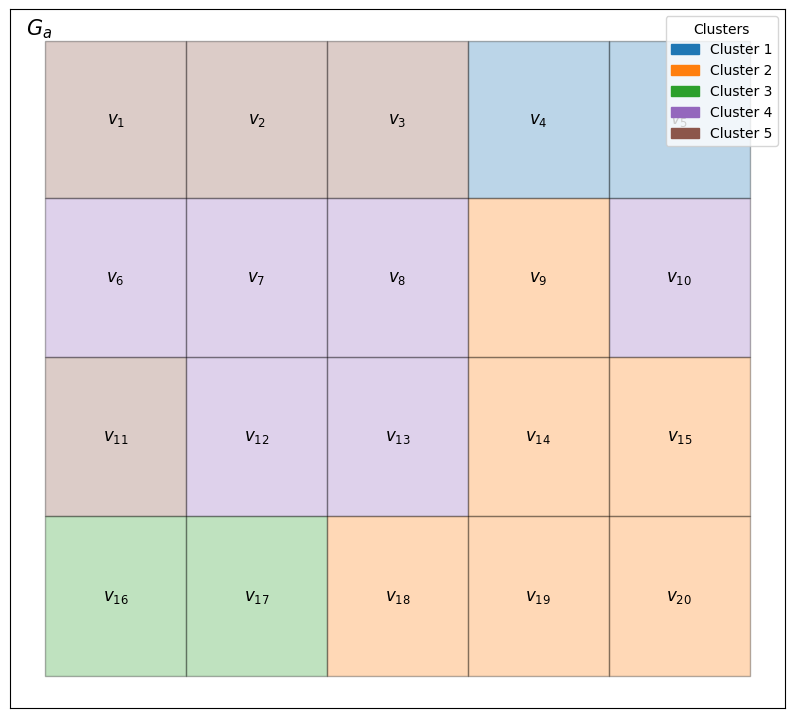

In [27]:
# Convert to Web Mercator projection (EPSG:3857)
df_wm2 = grids.to_crs(epsg=3857)

# Define the custom order for the legend
legend_order = ['1', '2', '3', '4', '5']  # Ensure these match the cluster_name values

# Custom labels and colours
custom_labels = {
    '1': 'Cluster 1',
    '2': 'Cluster 2',
    '3': 'Cluster 3',
    '4': 'Cluster 4',
    '5': 'Cluster 5'
}
custom_colors = {
    '1': '#1f77b4',  # Blue
    '2': '#ff7f0e',  # Orange
    '3': '#2ca02c',  # Blue
    '4': '#9467bd',  # Orange
    '5': '#8c564b'   # Orange
}

# Ensure all unique values are mapped
unique_attributes = df_wm2['cluster_name'].astype(str).unique()
category_colors = {attr: custom_colors.get(attr, '#cccccc') for attr in unique_attributes}

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
df_wm2.plot(
    color=df_wm2['cluster_name'].astype(str).map(category_colors),
    legend=False,
    ax=ax,
    edgecolor="k",
    alpha=0.3
)

# Custom legend in specified order
legend_patches = [
    mpatches.Patch(color=custom_colors[attr], label=custom_labels.get(attr, f"Cluster {attr}"))
    for attr in legend_order if attr in unique_attributes
]
ax.legend(handles=legend_patches, title="Clusters", loc='upper right')

# Adding LaTeX-style labels based on 'grid_name'
for x, y, label in zip(df_wm2.geometry.centroid.x, df_wm2.geometry.centroid.y, df_wm2['grid_name']):
    ax.text(x, y, f"$v_{{{label}}}$", fontsize=12, ha='center', va='center')

# Adding the label 'G_a' in the top left-hand corner
plt.text(0.02, 0.99, r"$G_a$", transform=ax.transAxes, fontsize=15, va='top', ha='left')

# Finalise the map
ax.set_xticks([])
ax.set_yticks([])
plt.show()

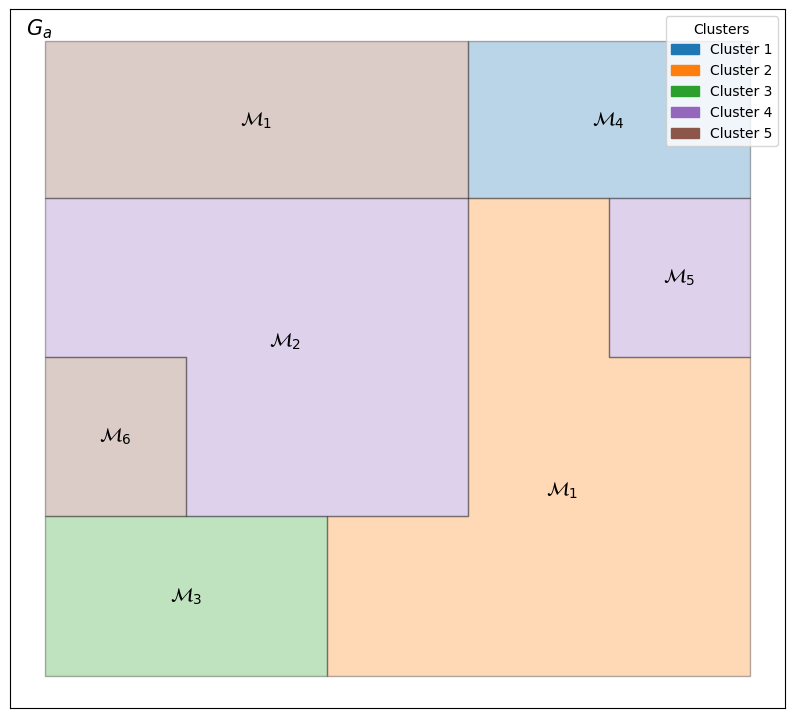

In [28]:
# Convert to Web Mercator projection
df_wm = blobs.to_crs(epsg=3857)

# Calculate the centroids of the polygons
df_wm['centroid'] = df_wm.geometry.centroid

# Manually assign colours to clusters
custom_colors = {
    '1': '#1f77b4',  # Blue
    '2': '#ff7f0e',  # Orange
    '3': '#2ca02c',  # Green
    '4': '#9467bd',  # Purple
    '5': '#8c564b'   # Brown
}

# Map the colours to the cluster_name column
df_wm['color'] = df_wm['cluster_name'].astype(str).map(custom_colors)

# Plot the polygons with the assigned colours
fig, ax = plt.subplots(figsize=(10, 10))
df_wm.plot(ax=ax, color=df_wm['color'], edgecolor='k', alpha=0.3)

# Create custom legend
cluster_labels = [f'Cluster {i}' for i in custom_colors.keys()]
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in zip(cluster_labels, custom_colors.values())]

plt.legend(handles=legend_patches, title='Clusters', loc='upper right')

# Adding LaTeX-style labels for each polygon based on blob_id
latex_labels = {
    1: r'$\mathcal{M}_4$',
    2: r'$\mathcal{M}_1$',
    3: r'$\mathcal{M}_3$',
    4: r'$\mathcal{M}_5$',
    5: r'$\mathcal{M}_2$',
    6: r'$\mathcal{M}_1$',
    7: r'$\mathcal{M}_6$'
}

# Add labels at the centroid positions based on blob_id
for idx, row in df_wm.iterrows():
    blob_id = row['blob_id']
    x, y = row['centroid'].x, row['centroid'].y
    if blob_id in latex_labels:
        ax.text(x, y, latex_labels[blob_id], fontsize=14, ha='center', va='center')

# Adding the label 'G_a' in the top left-hand corner
plt.text(0.02, 0.99, r"$G_a$", transform=ax.transAxes, fontsize=15, va='top', ha='left')

# Title and other plot settings
plt.xticks([])
plt.yticks([])
plt.show()